[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/NouamaneTazi/number-plate-recognition/blob/main/notebooks/DETR_license_plates.ipynb) 
<a href="https://colab.research.google.com/github/NouamaneTazi/number-plate-recognition/blob/main/notebooks/DETR_license_plates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

## Fine-tuning DETR for license plates detection

In this notebook, we are going to fine-tune [DETR](https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/) (end-to-end object detection with Transformers) on a [custom moroccan license plates dataset](https://www.kaggle.com/elmehditaf96/moroccan-vehicle-registration-plates). The goal for the model is to recognize license plates in pictures.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/05/Screenshot-from-2020-05-27-17-48-38.png)

Also big thanks to Niels Rogge from Huggingface for his [Transformers tutorials](https://github.com/NielsRogge/Transformers-Tutorials), as well as the creators of [this notebook](https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb) and [this notebook](https://www.kaggle.com/tanulsingh077/end-to-end-object-detection-with-transformers-detr), which helped me a lot in understanding how to fine-tune DETR on a custom dataset 



## Set up environment

In [9]:
!pip install -q timm pycocotools scipy
!pip install -qU pytorch-lightning transformers
!pip install fiftyone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 3.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 MB 3.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 5.7 MB/s eta 0:00:0000:01
  Using cached plotly-5.11.0-py2.py3-none-any.whl (15.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.0/30.0 MB 2.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━

## Download + preprocess data

Here we download the [license plates dataset](https://www.kaggle.com/elmehditaf96/moroccan-vehicle-registration-plates) hosted on kaggle (in [YOLOv4 format](https://github.com/AlexeyAB/darknet)) and convert it to [COCO Object Detection Format](https://cocodataset.org/#format-data).

We can use [fiftyone's converter tool](https://voxel51.com/docs/fiftyone/recipes/convert_datasets.html) for that.

For the sake of demo on kaggle we're only gonna use 20 images from that dataset.

In [2]:
!cd ../input/coco-lp-preview/coco_lp/ && ls

## Create PyTorch dataset + dataloaders

Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add a feature extractor (`DetrFeatureExtractor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [5]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

Based on the class defined above, we create training and validation datasets.

In [6]:
from transformers import DetrFeatureExtractor

img_folder = "../input/coco-lp-preview/coco_lp"

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{img_folder}/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=f'{img_folder}/val', feature_extractor=feature_extractor, train=False)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '../input/coco-lp-preview/coco_lp/train/custom_train.json'

As you can see, this dataset is tiny:

In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

NameError: name 'train_dataset' is not defined

Let's verify an example by visualizing it. We can access the COCO API of the dataset by typing `train_dataset.coco`. 

Image n°11


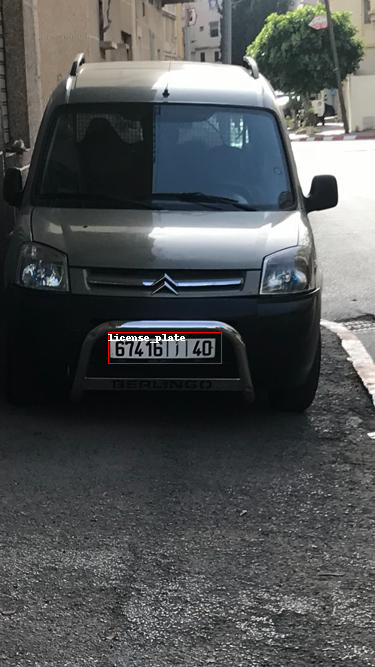

In [6]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{img_folder}/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

Next, let's create corresponding dataloaders. We define a custom `collate_fn` to batch images together. As DETR resizes images to have a min size of 800 and a max size of 1333, images can have different sizes. We pad images (`pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask` to indicate which pixels are real (1)/which are padding (0).  

In [7]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

Let's verify the keys of a single batch:

In [8]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

Let's verify the shape of the `pixel_values`, and check the `target`::

In [9]:
pixel_values, target = train_dataset[0]

In [10]:
pixel_values.shape

torch.Size([3, 1333, 750])

In [11]:
print(target)

{'boxes': tensor([[0.8667, 0.5578, 0.2250, 0.1047]]), 'class_labels': tensor([0]), 'image_id': tensor([1]), 'area': tensor([23548.9121]), 'iscrowd': tensor([0]), 'orig_size': tensor([1280,  720]), 'size': tensor([1333,  750])}


## Train the model using PyTorch Lightning

Here we define a `LightningModule`, which is an `nn.Module` with some extra functionality.

For more information regarding PyTorch Lightning, I recommend the [docs](https://pytorch-lightning.readthedocs.io/en/latest/?_ga=2.35105442.2002381006.1623231889-1738348008.1615553774) as well as the [tutorial notebooks](https://github.com/PyTorchLightning/lightning-tutorials/tree/aeae8085b48339e9bd9ab61d81cc0dc8b0d48f9c/.notebooks/starters). 

You can of course just train the model in native PyTorch as an alternative.

In [12]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

We could start Tensorboard if we'd like to monitor the training, since Pytorch Lightning automatically logs to it.

In [13]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Here we define the model, and verify the outputs.

In [14]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Downloading:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/159M [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negat

The logits are of shape `(batch_size, num_queries, number of classes + 1)`. We model internally adds an additional "no object class", which explains why we have one additional output for the class dimension. 

In [15]:
outputs.logits.shape

torch.Size([4, 100, 2])

Next, let's train! We train for a maximum of 300 training steps, and also use gradient clipping. You can refresh Tensorboard above to check the various losses.

In [16]:
from pytorch_lightning import Trainer
from tqdm.notebook import tqdm

trainer = Trainer(gpus=1, max_steps=100, gradient_clip_val=0.1)
trainer.fit(model)

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

For the training I used [Sagemaker Studio Lab](https://studiolab.sagemaker.aws/) which offers performant GPUs. So don't hesitate to reduce the batch size if you run into memory errors.

In [17]:
!nvidia-smi

Thu Dec 23 13:52:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    40W / 250W |   1427MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Inference (+ visualization)

Let's visualize the predictions of DETR on the first image of the validation set.

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrTimmConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (act2): ReLU(inplace=True)
                (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn3)

In [19]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [20]:
def visualize_predictions(image, outputs, threshold=0.9, keep_highest_scoring_bbox=False):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  if keep_highest_scoring_bbox:
    keep = probas.max(-1).values.argmax()
    keep = torch.tensor([keep])
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
    
  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [21]:
it = iter(range(1500))

torch.Size([1, 3, 1332, 749])


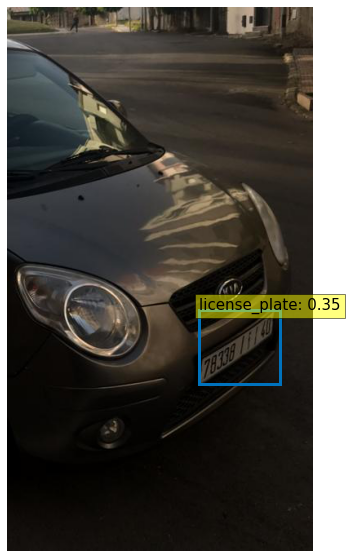

In [22]:
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[next(it)]

pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)

image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{img_folder}/val', image['file_name']))

visualize_predictions(image, outputs, threshold=0.3, keep_highest_scoring_bbox=True)

In [23]:
trainer.save_checkpoint("detr_model.ckpt")

I hope you find this notebook useful. If you have any questions, please don't hesitate to contact me.

Also note that this is only the license plate detection part, we can also use this model for the characters segmentation , followed by an OCR. (you can check [this paper](https://www.researchgate.net/publication/353034031_An_Improved_Character_Recognition_Framework_for_Containers_Based_on_DETR_Algorithm) for more info)

![](https://www.mdpi.com/sensors/sensors-21-04612/article_deploy/html/images/sensors-21-04612-g001.png)

Unfortunately I'm quite busy lately, but I'll try to post the rest of the notebooks soon. 